In [1]:
import os
import re
from textblob import TextBlob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk import word_tokenize
from nltk import ngrams
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english')+list(string.punctuation))

os.chdir('C:/Users/AGB/Desktop/WeCloud_Materials/Project/Subreddit_Submissions')
print(os.getcwd())

C:\Users\AGB\Desktop\WeCloud_Materials\Project\Subreddit_Submissions


## Merge all DFs into one

In [2]:
subreddits = ['SandersForPresident','socialism','Anarchism','democrats','Progressive','communism','Liberal','LateStageCapitalism',
              'The_Donald','Libertarian','Conservative','Republican','Anarcho_Capitalism',
             'politics','NeutralPolitics']

df = pd.DataFrame([])

for i in subreddits: 
    tempdf = pd.read_csv(i+'_submissions.csv')
    tempdf['subreddit'] = i
    df = pd.concat([df,tempdf])

df.reset_index(drop=True,inplace=True)
print(df['subreddit'].value_counts())
df['subreddit'].value_counts()/len(df)

The_Donald             1000
Anarcho_Capitalism     1000
Republican             1000
Progressive            1000
NeutralPolitics        1000
Liberal                1000
communism              1000
Conservative           1000
democrats               999
politics                999
Anarchism               998
SandersForPresident     997
Libertarian             997
socialism               995
LateStageCapitalism     990
Name: subreddit, dtype: int64


The_Donald             0.066778
Anarcho_Capitalism     0.066778
Republican             0.066778
Progressive            0.066778
NeutralPolitics        0.066778
Liberal                0.066778
communism              0.066778
Conservative           0.066778
democrats              0.066711
politics               0.066711
Anarchism              0.066644
SandersForPresident    0.066578
Libertarian            0.066578
socialism              0.066444
LateStageCapitalism    0.066110
Name: subreddit, dtype: float64

## Data Cleaning

In [3]:
from urllib.parse import urlparse
# Get url from submissions and drop original url feature
df['clean_url'] = list(map((lambda i: urlparse(i).netloc), df['url']))
df.drop('url',axis=1,inplace=True)
df.head()

,id,score,title,subreddit,clean_url
0,5p1syn,87260,Should've been Bernie,SandersForPresident,upload.wikimedia.org
1,7gvy34,57331,This is Senator Bernie Sanders. He has NOT sol...,SandersForPresident,i.redd.it
2,5cwtav,54737,Sign If You Agree: Make Bernie Sanders Senate ...,SandersForPresident,bernieforleader.com
3,48bqz6,43447,"Reddit, you have supported me since this campa...",SandersForPresident,www.reddit.com
4,49mf71,35885,BREAKING: Bernie Sanders wins the Democratic p...,SandersForPresident,twitter.com


In [4]:
# Define processing and cleaning functions 
def processText(text):
    # Convert to lower case
    text = text.lower()
    
    # Convert www.* or https?://* to URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',text)
    
    # Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
      
    # Trim
    text = text.strip('\'"')
    
    return text

def replaceTwoOrMore(s):
    # Look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

In [5]:
# NLTK Processing - must manually select how to stem / lemmatize
porter = nltk.PorterStemmer() #porter.stem
snowball = nltk.SnowballStemmer('english') #snowball.stem
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer() #wordnet_lemmatizer.lemmatize

# Add list of additional stop words
add_stop = ["'s","n't","''","'m",":",")"]

def NLTKprocess(text):
    tokens = nltk.word_tokenize(text)
    stemmed_list = []
    for i in tokens:
        if(i in stop or re.search("^[a-zA-Z0-9\-']*$", i) is None):
            continue
        else:
            lemma = wordnet_lemmatizer.lemmatize(i)
            if lemma not in add_stop:
                stemmed_list.append(lemma)
    return stemmed_list

# Ngram with no stop words or stemming
def NLTKngram(text,n):
    return list(ngrams(text.split(), n))

In [6]:
# Create feature from cleaned up titles
clean_text = []

for i in df['title']:
    clean_text.append(processText(i))

df['new_title'] = clean_text

In [7]:
# Create feature of tokens from clean titles
tokens = []

for i in df['new_title']:
    tokens.append(NLTKprocess(i)) 

df['tokens'] = tokens

In [8]:
# Remove comments below minimum length
minimum_len = 1

df = df[df['tokens'].map(len) > minimum_len]

In [9]:
df = df.reset_index(drop=True)
df[:20]

,id,score,title,subreddit,clean_url,new_title,tokens
0,5p1syn,87260,Should've been Bernie,SandersForPresident,upload.wikimedia.org,should've been bernie,"['ve, bernie]"
1,7gvy34,57331,This is Senator Bernie Sanders. He has NOT sol...,SandersForPresident,i.redd.it,this is senator bernie sanders. he has not sol...,"[senator, bernie, sander, sold, fellow, americ..."
2,5cwtav,54737,Sign If You Agree: Make Bernie Sanders Senate ...,SandersForPresident,bernieforleader.com,sign if you agree: make bernie sanders senate ...,"[sign, agree, make, bernie, sander, senate, mi..."
3,48bqz6,43447,"Reddit, you have supported me since this campa...",SandersForPresident,www.reddit.com,"reddit, you have supported me since this campa...","[reddit, supported, since, campaign, first, be..."
4,49mf71,35885,BREAKING: Bernie Sanders wins the Democratic p...,SandersForPresident,twitter.com,breaking: bernie sanders wins the democratic p...,"[breaking, bernie, sander, win, democratic, pr..."
5,7ejabn,35608,The FCC is getting ready to overturn #NetNeutr...,SandersForPresident,twitter.com,the fcc is getting ready to overturn netneutra...,"[fcc, getting, ready, overturn, netneutrality,..."
6,7kf8sf,35074,A Massive Class Warfare Attack,SandersForPresident,i.redd.it,a massive class warfare attack,"[massive, class, warfare, attack]"
7,5x3c1x,34787,Bill Introduced To End Federal Marijuana Prohi...,SandersForPresident,www.reddit.com,bill introduced to end federal marijuana prohi...,"[bill, introduced, end, federal, marijuana, pr..."
8,5rnj0f,34645,"Bernie on Twitter: ""Is there not one more Repu...",SandersForPresident,twitter.com,"bernie on twitter: ""is there not one more repu...","[bernie, twitter, one, republican, senator, st..."
9,4enj09,33532,Somebody Get This Man In The White House!,SandersForPresident,imgur.com,somebody get this man in the white house!,"[somebody, get, man, white, house]"


In [10]:
# Get list of top words by occurence
flatten = [item for sublist in df['tokens'] for item in sublist]
word_dist = nltk.FreqDist(flatten)

top_N = 15

rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
rslt[:50]

,Word,Frequency
0,trump,2381
1,sander,765
2,bernie,758
3,people,661
4,president,633
5,u,619
6,say,606
7,republican,601
8,new,492
9,state,480


## Sentiment Analysis

In [11]:
# Textblob sentiment analysis for polarity and subjectivity
sentiment_polarity = []
sentiment_subjectivity = []

for i in range(len(df['new_title'])):
    zen = TextBlob(df['new_title'].iloc[i])
    sentiment_polarity.append(zen.sentiment.polarity)
    sentiment_subjectivity.append(zen.sentiment.subjectivity)
    
df['blob_polarity'] = np.around(sentiment_polarity,2)
df['blob_subj'] = np.around(sentiment_subjectivity,2)

In [12]:
# Vader sentiment analysis for total score and components (negative, positive, neutral)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

vader_compound = []
vader_neg = []
vader_neu = []
vader_pos = []

for i in range(len(df['new_title'])):
    vader = analyser.polarity_scores(df['new_title'][i])
    vader_compound.append(vader['compound'])
    vader_neg.append(vader['neg'])
    vader_neu.append(vader['neu'])
    vader_pos.append(vader['pos'])
    
df['v_compound'] = np.around(vader_compound,2)
df['v_negative'] = np.around(vader_neg,2)
df['v_neutral'] = np.around(vader_neu,2)
df['v_positive'] = np.around(vader_pos,2)

## Reading Level

In [13]:
from textstat.textstat import textstat as ts

# Calculates the reading level with various metrics below
flesch = [] #http://www.readabilityformulas.com/flesch-grade-level-readability-formula.php
gunning_fog = [] #https://en.wikipedia.org/wiki/Gunning_fog_index
avg_syllables = []
difficult_words = []
num_words = []

for i in range(len(df['new_title'])):
    flesch.append(ts.flesch_kincaid_grade(df['new_title'][i]))
    gunning_fog.append(ts.gunning_fog(df['new_title'][i]))
    avg_syllables.append(ts.syllable_count(df['new_title'][i]) / ts.lexicon_count(df['new_title'][i]))
    difficult_words.append(ts.difficult_words(df['new_title'][i]) / ts.lexicon_count(df['new_title'][i]))
    num_words.append(ts.lexicon_count(df['new_title'][i]))
    
# Create new features
df['flesch'] = np.around(flesch,2)
df['gunning_fog'] = np.around(gunning_fog,2)
df['avg_syllables'] = np.around(avg_syllables,2)
df['difficult_words'] = np.around(difficult_words,2)
df['word_count'] = np.around(num_words,2)

# Remove negative values
df['flesch'] = df['flesch'].clip(lower=0)
df['gunning_fog'] = df['gunning_fog'].clip(lower=0)


In [14]:
df.head(5)

,id,score,title,subreddit,clean_url,new_title,tokens,blob_polarity,blob_subj,v_compound,v_negative,v_neutral,v_positive,flesch,gunning_fog,avg_syllables,difficult_words,word_count
0,5p1syn,87260,Should've been Bernie,SandersForPresident,upload.wikimedia.org,should've been bernie,"['ve, bernie]",0.00,0.00,0.00,0.00,1.00,0.00,0.0,3.20,1.00,0.00,3
1,7gvy34,57331,This is Senator Bernie Sanders. He has NOT sol...,SandersForPresident,i.redd.it,this is senator bernie sanders. he has not sol...,"[senator, bernie, sander, sold, fellow, americ...",0.00,0.00,-0.36,0.06,0.91,0.03,7.2,18.48,1.54,0.28,39
2,5cwtav,54737,Sign If You Agree: Make Bernie Sanders Senate ...,SandersForPresident,bernieforleader.com,sign if you agree: make bernie sanders senate ...,"[sign, agree, make, bernie, sander, senate, mi...",0.00,0.00,0.36,0.00,0.78,0.22,6.0,14.00,1.50,0.20,10
3,48bqz6,43447,"Reddit, you have supported me since this campa...",SandersForPresident,www.reddit.com,"reddit, you have supported me since this campa...","[reddit, supported, since, campaign, first, be...",0.33,0.62,0.73,0.00,0.72,0.28,4.4,16.80,1.29,0.25,24
4,49mf71,35885,BREAKING: Bernie Sanders wins the Democratic p...,SandersForPresident,twitter.com,breaking: bernie sanders wins the democratic p...,"[breaking, bernie, sander, win, democratic, pr...",0.35,0.35,0.57,0.00,0.71,0.29,10.7,26.00,1.90,0.50,10


In [31]:
#examine specific url
#df[df['clean_url']=='np.reddit.com']

In [16]:
submission_df = pd.DataFrame([])

# Number of outlets
top_n_outlets = 20

# Outlet row names
row_name = []
for i in range(top_n_outlets):
    row_name.append('outlet_'+str(i+1))
submission_df['row_name'] = row_name    

# Initialize rows with titles included
total_outlets = ['total_outlets']
top_5_concentration = ['top_5_conc.']
top_10_concentration = ['top_10_conc.']
images = ['images_prop']

avg_sentiment = ['avg_sentiment']
# Polarity represents the average of the sentiment when it is non-zero
avg_negative = ['avg_negative'] 
avg_neutral = ['avg_neutral']
avg_positive = ['avg_positive']

avg_flesch = ['avg_flesch']
avg_syllables = ['avg_syllables']
avg_difficult_words = ['avg_difficult_words']


# Loops through all the subreddits and adds the features
for i in subreddits:
    sub_df = df[df['subreddit']==i].copy()
    sub_df['clean_url'] = sub_df['clean_url'].replace({ 'i.redd.it' : 'image','i.reddituploads.com':'image',
                                                       'i.imgur.com' : 'image', 'imgur.com' : 'image',
                                                       '78.media.tumblr.com' : 'image','68.media.tumblr.com':'image',
                                                       'np.reddit.com':'reddit','www.reddit.com':'reddit', 
                                                      'youtube.com':'www.youtube.com','youtu.be':'www.youtube.com',
                                                       'i.sli.mg':'sli.mg'})
    value_count = sub_df['clean_url'].value_counts()

    media_stats = []
    for j in range(top_n_outlets):
        if j < len(value_count):
            media_stats.append([value_count.index[j],value_count[j]])
        else:
            media_stats.append(np.NaN)
        
    submission_df[i] = media_stats
    
    total_outlets.append(len(value_count.index.unique()))
    top_5_concentration.append(sum(value_count[:5])/value_count.sum())
    top_10_concentration.append(sum(value_count[:10])/value_count.sum())
    images.append((value_count['image'] if value_count[:10].index.str.contains('image').any() else 0)/value_count.sum())  
    
    avg_sentiment.append(sub_df['v_compound'].mean())
    avg_negative.append(sub_df['v_negative'][sub_df['v_negative']>0].mean())
    avg_neutral.append(sub_df['v_neutral'][sub_df['v_neutral']>0].mean())
    avg_positive.append(sub_df['v_positive'][sub_df['v_positive']>0].mean())

    avg_flesch.append(sub_df['flesch'].mean())
    avg_syllables.append(sub_df['avg_syllables'].mean())
    avg_difficult_words.append(sub_df['difficult_words'].mean())
    
submission_df.loc[len(submission_df)]= total_outlets
submission_df.loc[len(submission_df)]= top_5_concentration
submission_df.loc[len(submission_df)]= top_10_concentration
submission_df.loc[len(submission_df)]= images
submission_df.loc[len(submission_df)]= avg_sentiment
submission_df.loc[len(submission_df)]= avg_negative
submission_df.loc[len(submission_df)]= avg_neutral
submission_df.loc[len(submission_df)]= avg_positive
submission_df.loc[len(submission_df)]= avg_flesch
submission_df.loc[len(submission_df)]= avg_syllables
submission_df.loc[len(submission_df)]= avg_difficult_words

In [17]:
words_df = pd.DataFrame([])

# Number of top words
top_n_words = 10

# Word row names
row_name = []
for i in range(top_n_words):
    row_name.append('word_'+str(i+1))
words_df['row_name'] = row_name
    
for i in subreddits:
    sub_df = df[df['subreddit']==i].copy()
    # Top words by occurence
    flatten = [item for sublist in sub_df['tokens'] for item in sublist]
    word_dist = nltk.FreqDist(flatten)
    rslt = word_dist.most_common(top_n_words)
    words_df[i] = rslt

submission_df = pd.concat([submission_df,words_df])

In [18]:
submission_df

,row_name,SandersForPresident,socialism,Anarchism,democrats,Progressive,communism,Liberal,LateStageCapitalism,The_Donald,Libertarian,Conservative,Republican,Anarcho_Capitalism,politics,NeutralPolitics
0,outlet_1,"[reddit, 268]","[image, 444]","[image, 494]","[image, 165]","[www.salon.com, 76]","[image, 183]","[www.rawstory.com, 55]","[image, 728]","[image, 415]","[image, 521]","[image, 338]","[image, 131]","[image, 558]","[thehill.com, 138]","[reddit, 990]"
1,outlet_2,"[twitter.com, 151]","[reddit, 53]","[reddit, 92]","[twitter.com, 78]","[www.rawstory.com, 57]","[reddit, 154]","[thinkprogress.org, 52]","[reddit, 13]","[reddit, 93]","[reddit, 28]","[www.dailywire.com, 53]","[reddit, 40]","[reddit, 57]","[www.independent.co.uk, 92]","[www.nytimes.com, 2]"
2,outlet_3,"[image, 128]","[twitter.com, 33]","[twitter.com, 36]","[www.washingtonpost.com, 74]","[thinkprogress.org, 48]","[www.telesurtv.net, 79]","[www.salon.com, 50]","[pbs.twimg.com, 10]","[twitter.com, 89]","[reason.com, 28]","[www.foxnews.com, 34]","[thehill.com, 37]","[www.youtube.com, 42]","[www.washingtonpost.com, 82]","[reason.com, 1]"
3,outlet_4,"[www.youtube.com, 39]","[www.youtube.com, 28]","[www.youtube.com, 23]","[thehill.com, 51]","[www.alternet.org, 37]","[www.youtube.com, 59]","[www.huffingtonpost.com, 50]","[twitter.com, 7]","[sli.mg, 73]","[www.youtube.com, 24]","[www.thegatewaypundit.com, 30]","[www.foxnews.com, 31]","[i.magaimg.net, 16]","[www.nytimes.com, 35]","[www.dailykos.com, 1]"
4,outlet_5,"[thehill.com, 18]","[www.theguardian.com, 19]","[www.theguardian.com, 14]","[www.rawstory.com, 37]","[www.huffingtonpost.com, 36]","[twitter.com, 21]","[www.washingtonpost.com, 46]","[www.theguardian.com, 6]","[www.youtube.com, 41]","[twitter.com, 14]","[dailycaller.com, 27]","[www.youtube.com, 30]","[twitter.com, 15]","[www.cnn.com, 33]","[www.journalism.org, 1]"
5,outlet_6,"[berniesanders.com, 17]","[www.independent.co.uk, 16]","[www.rawstory.com, 12]","[thinkprogress.org, 34]","[image, 35]","[www.rt.com, 18]","[reddit, 32]","[i.redditmedia.com, 5]","[i.magaimg.net, 18]","[www.nytimes.com, 6]","[www.breitbart.com, 24]","[www.politico.com, 25]","[sli.mg, 13]","[reddit, 32]","[www.dancarlin.com, 1]"
6,outlet_7,"[www.facebook.com, 16]","[www.washingtonpost.com, 12]","[socialistworker.org, 8]","[www.huffingtonpost.com, 24]","[www.washingtonpost.com, 31]","[en.granma.cu, 14]","[www.vox.com, 28]","[www.youtube.com, 2]","[www.breitbart.com, 14]","[www.politico.com, 6]","[reddit, 16]","[dailycaller.com, 20]","[71republic.com, 8]","[www.newsweek.com, 32]","[www.scientificamerican.com, 1]"
7,outlet_8,"[www.politico.com, 16]","[www.commondreams.org, 12]","[www.independent.co.uk, 8]","[www.salon.com, 21]","[www.politicususa.com, 29]","[www.theguardian.com, 13]","[thehill.com, 27]","[www.nytimes.com, 2]","[dailycaller.com, 13]","[www.foxnews.com, 6]","[nypost.com, 11]","[hotair.com, 20]","[kek.gg, 8]","[www.businessinsider.com, 32]",NaN
8,outlet_9,"[go.berniesanders.com, 12]","[www.telesurtv.net, 12]","[www.theonion.com, 5]","[www.nytimes.com, 20]","[www.motherjones.com, 27]","[www.bbc.com, 12]","[www.politico.com, 25]","[en.wikipedia.org, 2]","[archive.is, 13]","[www.washingtonpost.com, 6]","[thehill.com, 10]","[www.nytimes.com, 19]","[www.zerohedge.com, 7]","[thinkprogress.org, 28]",NaN
9,outlet_10,"[www.huffingtonpost.com, 12]","[pbs.twimg.com, 10]","[www.reuters.com, 5]","[www.thedailybeast.com, 20]","[www.theguardian.com, 23]","[www.independent.co.uk, 10]","[www.theguardian.com, 25]","[i.imgflip.com, 2]","[www.foxnews.com, 9]","[www.forbes.com, 5]","[www.youtube.com, 9]","[www.breitbart.com, 18]","[mises.org, 7]","[www.politico.com, 25]",NaN


In [33]:
# Export results to csv
#submission_df.to_csv('!Cons_Submissions_Summary.csv',index=False)

# Media PCA 

In [19]:
df['clean_url'] = df['clean_url'].replace({ 'i.redd.it' : 'image','i.reddituploads.com':'image',
                                                       'i.imgur.com' : 'image', 'imgur.com' : 'image',
                                                       '78.media.tumblr.com' : 'image','68.media.tumblr.com':'image',
                                                       'np.reddit.com':'reddit','www.reddit.com':'reddit', 
                                                      'youtube.com':'www.youtube.com','youtu.be':'www.youtube.com',
                                                       'i.sli.mg':'sli.mg'})
table = pd.pivot_table(df, values='id', index=['subreddit'], columns=['clean_url'], aggfunc='count')
table.fillna(0,inplace=True)
table

clean_url,1.bp.blogspot.com,100percentfedup.com,2.bp.blogspot.com,2020.washingtonexaminer.com,24.media.tumblr.com,24flashnews.com,25.media.tumblr.com,3.bp.blogspot.com,31.media.tumblr.com,37.media.tumblr.com,...,www.youngcons.com,www.youngpioneertours.com,www.youtube.com,www.zazzle.com,www.zerohedge.com,www1.cbn.com,xkcd.com,yougov.co.uk,yournewswire.com,youthandeldersja.wordpress.com
subreddit,,,,,,,,,,,,,,,,,,,,,
Anarchism,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anarcho_Capitalism,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,42.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0
Conservative,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,9.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0
LateStageCapitalism,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Liberal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Libertarian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,24.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
NeutralPolitics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Progressive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,17.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Republican,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Set minimum threshold for number of media posts in subreddit
threshold = 2

for col in table.columns:
    if table[col].sum() < threshold:
        table.drop(col,inplace=True,axis=1)
        
#table.drop(['image'],axis=1,inplace=True)
table.drop(['NeutralPolitics'],inplace=True)

In [21]:
from sklearn.decomposition import PCA

# Perform PCA to visualize similarity between subreddits in terms of media outlets being shared
pca = PCA(n_components=2)

pca.fit(table)
PCA = pca.transform(table)
media_PCA = pd.DataFrame(PCA,columns=['PCA1','PCA2'])
media_PCA.insert(0, 'subreddits', table.index)

In [22]:
media_PCA

,subreddits,PCA1,PCA2
0,Anarchism,200.380369,29.324896
1,Anarcho_Capitalism,266.804758,-4.204156
2,Conservative,50.579798,-47.420576
3,LateStageCapitalism,434.440572,-54.897907
4,Liberal,-303.780498,-58.482364
5,Libertarian,229.746662,-33.369138
6,Progressive,-266.868383,-74.726368
7,Republican,-159.606148,-25.543571
8,SandersForPresident,-168.917810,234.002770
9,The_Donald,125.763768,63.181572


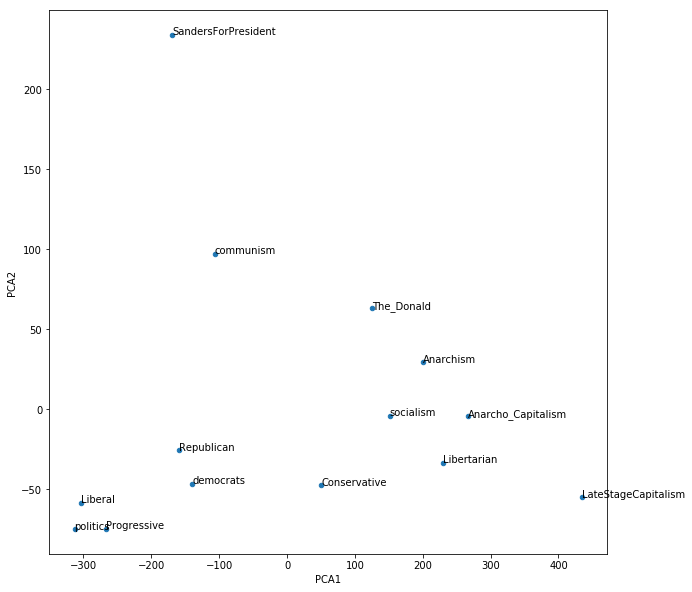

In [23]:
ax = media_PCA.plot.scatter(x='PCA1', y='PCA2',figsize = (10,10))
for i, txt in enumerate(media_PCA.subreddits):
    ax.annotate(txt, (media_PCA['PCA1'].iat[i],media_PCA['PCA2'].iat[i]))
plt.show()

# Mean PCA

In [24]:
dummy_CODE = df['clean_url']
dummy_CODE = pd.get_dummies(dummy_CODE)

In [25]:
threshold = 2
cut = dummy_CODE.sum()<threshold
dropcols = cut.index[cut==True]
dummy_CODE.drop(dropcols,inplace=True,axis=1)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(dummy_CODE)
PCA = pca.transform(dummy_CODE)
media_PCA = pd.DataFrame(PCA,columns=['PCA1','PCA2'])
media_PCA.insert(0, 'subreddits', df['subreddit'])

In [27]:
table = pd.pivot_table(media_PCA, index=['subreddits'], aggfunc='mean')

In [28]:
table.drop(['NeutralPolitics'],inplace=True)

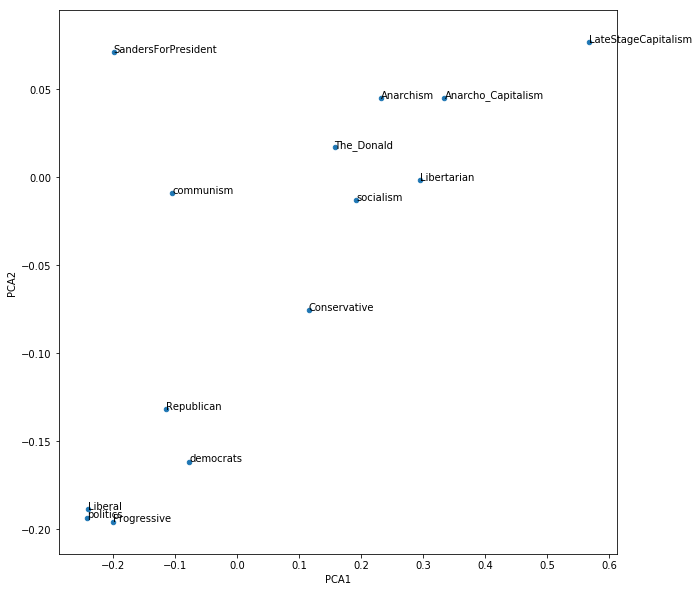

In [29]:
ax = table.plot.scatter(x='PCA1', y='PCA2',figsize = (10,10))
for i, txt in enumerate(table.index):
    ax.annotate(txt, (table['PCA1'].iat[i],table['PCA2'].iat[i]))
plt.show()